In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [2]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[(training_data['Well Name'] != 'SHANKLE')]

The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [3]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [4]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [5]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


The label vector is just the `Facies` column:

In [6]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [7]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

In [8]:
X_blind = well_features
X_blind.fillna(value=-9999,inplace=True)
X_blind = X_blind.values

In [9]:
training_data.fillna(value=-9999,inplace=True)
len(training_data)

3700

In [90]:
X_train = training_data.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1).values
y_train = training_data['Facies'].values
X_train

array([[ 77.45 ,   0.664,   9.9  , ...,   4.6  ,   1.   ,   1.   ],
       [ 78.26 ,   0.661,  14.2  , ...,   4.1  ,   1.   ,   0.979],
       [ 79.05 ,   0.658,  14.8  , ...,   3.6  ,   1.   ,   0.957],
       ..., 
       [ 49.719,   0.964,   2.925, ...,   3.19 ,   2.   ,   0.669],
       [ 51.469,   0.965,   3.083, ...,   3.152,   2.   ,   0.661],
       [ 50.031,   0.97 ,   2.609, ...,   3.295,   2.   ,   0.653]])

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [91]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import robust_scale

In [99]:
X_train = robust_scale(X_train)

In [103]:
n_clusters = 20
n_Facies = 9

In [104]:
ward = AgglomerativeClustering(n_clusters=20,linkage='ward').fit(X_train)

In [107]:
prediction=np.zeros((n_clusters,n_Facies))
for i in range(len(y_train)):
    prediction[ward.labels_[i],y_train[i]-1]+=1

        

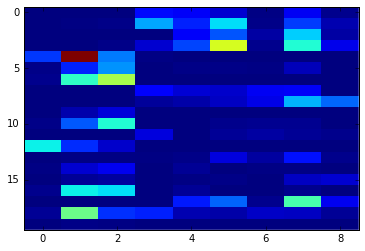

In [111]:
label = ward.labels_
plt.imshow(prediction,aspect='auto',interpolation='None')

In [87]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

NameError: name 'clf' is not defined

Let's see how we did with the confusion matrix:

In [25]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

In [26]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.3f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.3f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.457


IndexError: index 8 is out of bounds for axis 0 with size 8

We managed 0.75 using the test data, but it was from the same wells as the training data. This more reasonable test does not perform as well... but does remarkably well on the adjacent facies predictions. 

In [171]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

NameError: name 'facies_labels' is not defined

In [ ]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [205]:
compare_facies_plot(blind, 'Prediction', facies_colors)

NameError: name 'facies_colors' is not defined

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [34]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [35]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [36]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [37]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

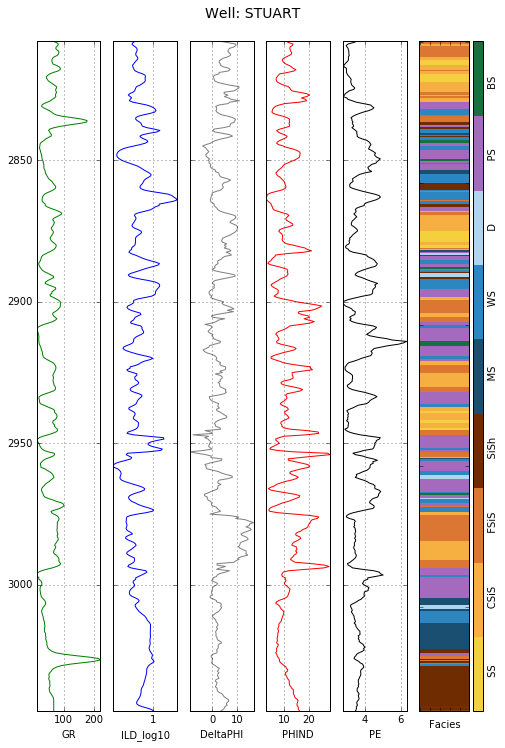

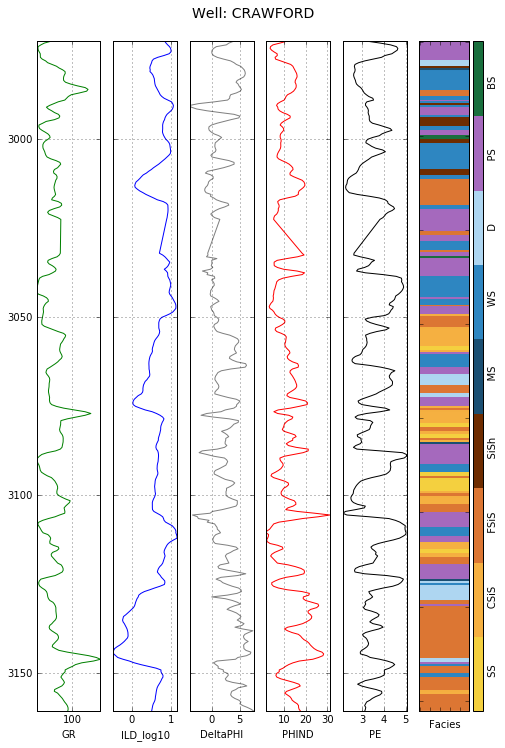

In [38]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [39]:
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)